In [1]:
#pip install pandas --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import re
import sklearn
import statsmodels

In [3]:
# Set default figure and axes facecolor to white
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# Set default text and axes color to black
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.titlecolor'] = 'black'

In [4]:
directory = 'Rep 7'
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    
# Delete all files in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

Failed to delete Rep 7/.ipynb_checkpoints. Reason: name 'shutil' is not defined


In [5]:
excel = 'INR21700-P42A_OCV different temperatures.xlsx'
file = pd.ExcelFile(excel)

sheet_names = file.sheet_names
sheet = sheet_names[0]
print(*sheet_names, sep='\n')

OCV-Temp
工作表1


In [6]:
data = pd.read_excel(excel, sheet, header=1, usecols=range(1,7))
temps_cols = [col for col in data.columns if 'SoC' not in col]
temps = np.array([int(re.sub(r'[^0-9-]', '', col)) for col in data.columns if 'SoC' not in col])

temp_plot = 'Temperature (Celsius)'
soc_plot = 'SoC (%)'
volt_plot = 'Voltage (V)'

# Create a function of voltage in terms of the temp and SoC.

In [7]:
sets = {}
for temp, col in zip(temps, temps_cols):
    sets[temp] = pd.DataFrame({soc_plot:np.array(data['SoC']),
                               volt_plot:data[col]})

In [8]:
list(sets.keys())[0]

-30

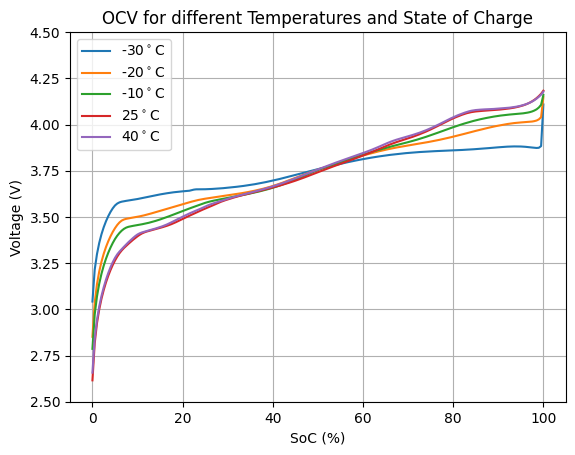

In [9]:
for key in list(sets.keys())[:]:
    x = sets[key][soc_plot]*100
    y = sets[key][volt_plot]
    plt.plot(x, y, label=f'{key}$^\\circ$C')
    
plt.ylim(2.5, 4.5)
plt.ylabel(volt_plot)
plt.xlabel(soc_plot)
plt.legend()
plt.title('OCV for different Temperatures and State of Charge')
plt.grid()
plt.savefig('Rep 7/OCV_data.png')
plt.show()

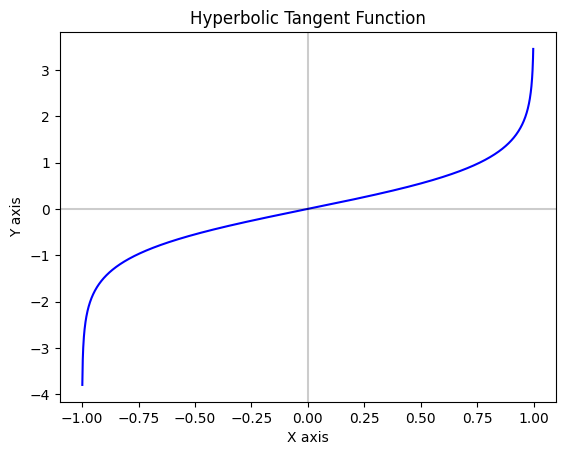

In [10]:
x = np.arange(-.999, .999, .001)
a = 1
b = 1
c = 0
d = 0
y = np.arctanh(x)

plt.plot(x,y, color = 'blue')
plt.axvline(x=0, color ='black', alpha=0.2)
plt.axhline(y=0, color ='black', alpha=0.2)
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Hyperbolic Tangent Function')
plt.savefig('Rep 7/tanh_basic_function.png')
plt.show()
#plt.ylim(2.3,4.5)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


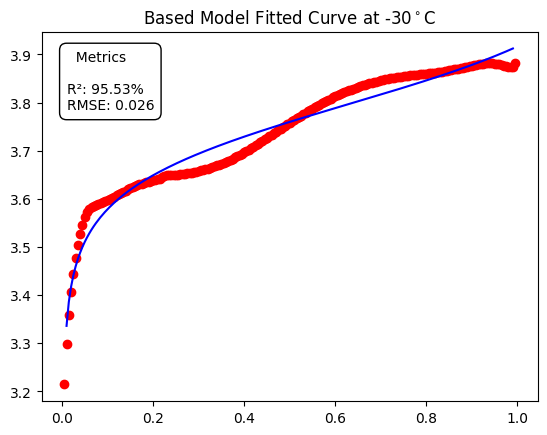

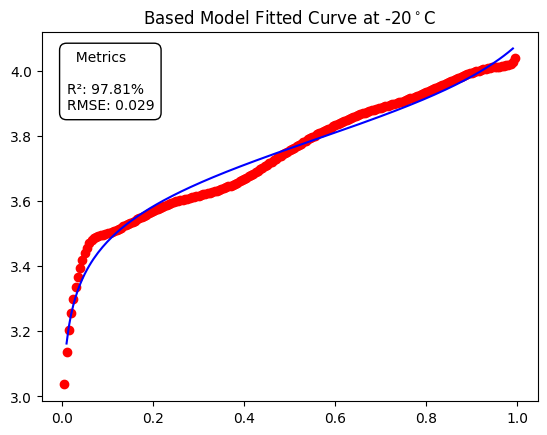

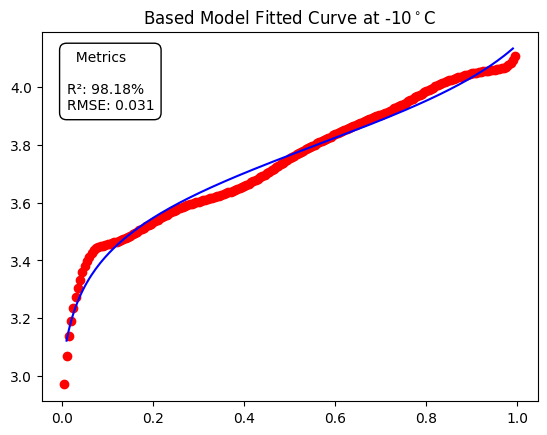

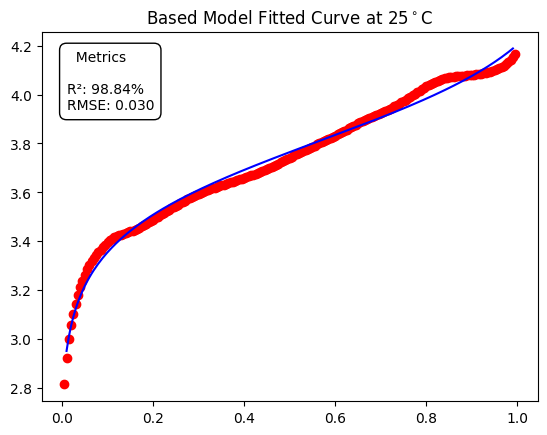

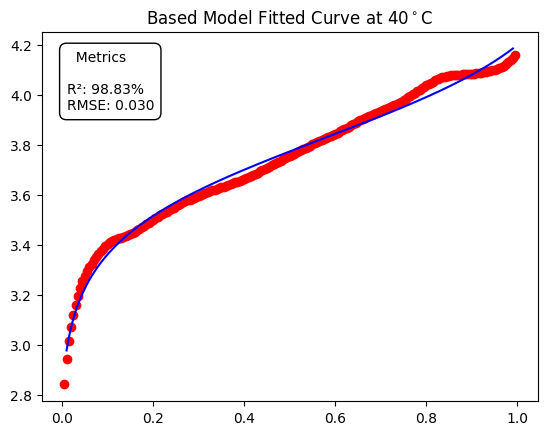

In [11]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, root_mean_squared_error

def function(x, a, b, c, d):
    return a * np.arctanh(b*x - c) + d
    

params = {}
#print('      L            k          x0')
for key in list(sets.keys())[:]:
    x = sets[key][soc_plot][1:-1]
    x_pred = np.linspace(0.01, .99, len(x))
    y = sets[key][volt_plot][1:-1]
    initial_guess = [.3, 2, 1, 3.7]
    popt, _ = curve_fit(function, x, y, maxfev = 10000, p0=initial_guess)
    y_pred = function(x_pred, *popt)
    params[key] = pd.Series(popt, dtype='float64')
    r2 = r2_score(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    plt.scatter(x,y, color='red', label='Data')
    plt.plot(x_pred,y_pred, color='blue', label='Prediction')
    plt.title(f'Based Model Fitted Curve at {key}$^\\circ$C')
    
    metric_text = f'  Metrics  \n\nR²: {r2:.2%}\nRMSE: {rmse:.3f}'
    plt.text(0.05, 0.95, metric_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                                                edgecolor='black', facecolor='white'))

    plt.savefig(f'Rep 7/{key}C_tanh_only.png')
    plt.show()

params['Coef'] = pd.Series(['a', 'b', 'c', 'd'], dtype='object')

In [12]:
df = pd.DataFrame(params)
df

,-30,-20,-10,25,40,Coef
0,0.175946,0.272098,0.340951,0.398341,0.407696,a
1,1.597807,1.787076,1.749412,1.745932,1.709074,b
2,1.005378,0.998222,0.980631,0.991152,0.986755,c
3,3.796793,3.789988,3.800290,3.812012,3.829039,d


In [13]:
df.set_index('Coef', inplace=True)
# Reset index to make 'Coef' a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'Coef'}, inplace=True)

# Melt the DataFrame
melted_df = pd.melt(df, id_vars=['Coef'], var_name='Temperature', value_name='Value')

# Pivot the DataFrame
pivoted_df = melted_df.pivot(index='Temperature', columns='Coef', values='Value').reset_index()

params_df = pivoted_df.rename_axis(None, axis=1)
params_df

,Temperature,a,b,c,d
0,-30,0.175946,1.597807,1.005378,3.796793
1,-20,0.272098,1.787076,0.998222,3.789988
2,-10,0.340951,1.749412,0.980631,3.800290
3,25,0.398341,1.745932,0.991152,3.812012
4,40,0.407696,1.709074,0.986755,3.829039


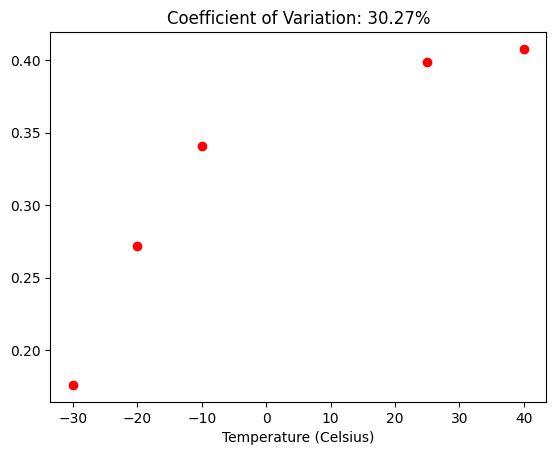

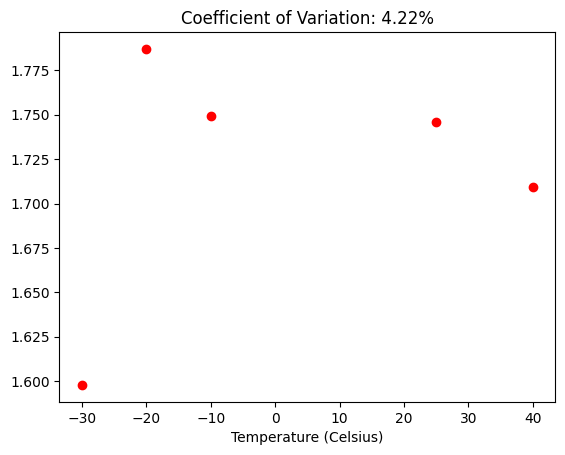

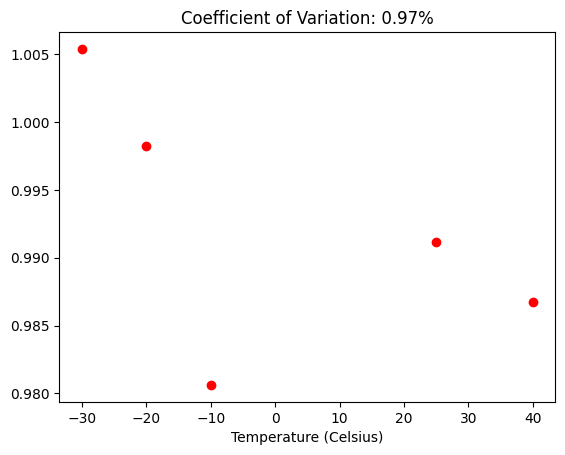

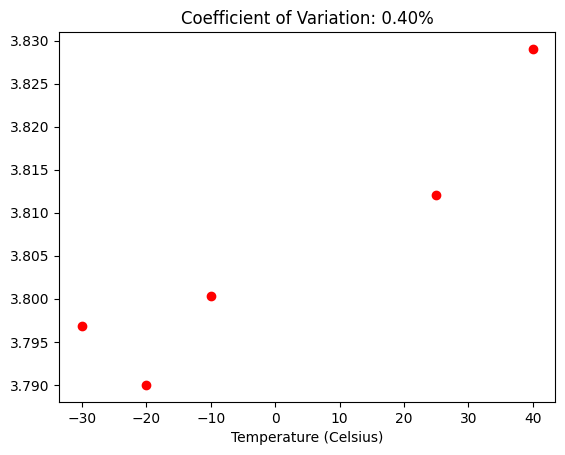

In [14]:
cvs = []
for col in ['A','B', 'C', 'D']:
    x = params_df['Temperature']
    y = params_df[col.lower()]
    mean = y.mean()
    std = y.std()
    cv = std/mean
    
    plt.scatter(x, y, color='red')
    plt.title(f'Coefficient of Variation: {cv:.2%}')
    plt.xlabel(temp_plot)
    #plt.legend()
    plt.savefig(f'Rep 7/coeff_{col}_variation.png')
    plt.show()
    cvs.append(cv)

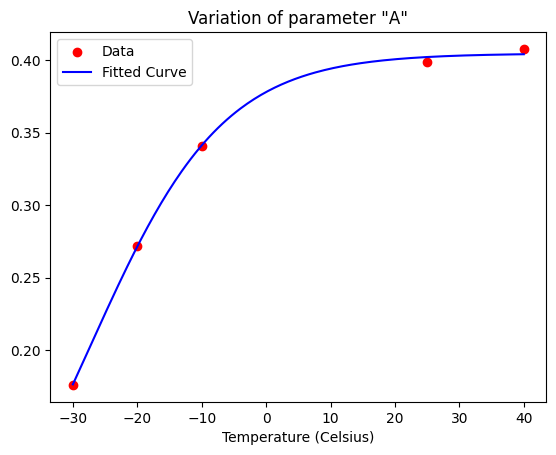

In [15]:
x = params_df['Temperature']
x_pred = np.linspace(-30,40,200)
y = params_df['a']

def sigmoid(x,f,g,h):
    return f/(1+np.exp(-g*x/10 + h))

popt_a, _ = curve_fit(sigmoid, x, y)
pred = sigmoid(x_pred, *popt_a)

plt.scatter(x,y, label='Data', color ='red')
plt.plot(x_pred,pred, label='Fitted Curve', color='blue')
plt.xlabel('Temperature (Celsius)')
plt.title('Variation of parameter "A"')
plt.legend()
plt.savefig('Rep 7/A_coef_fitted_curve.png')
plt.show()

In [16]:
# Estimate fixed values for b,c and d using mean

# function coef distribution
# a * np.arctanh(b*x - c) + d

b_coef = params_df['b'].mean()
c_coef = params_df['c'].mean()
d_coef = params_df['d'].mean()



$F(T, SoC) = \frac{f}{1+e^{-g\frac{T}{10}+h}}\cdot tanh^{-1}(b*SoC - c) + d$

0.40462029615554407 0.9699935514422887 -2.651971222330788


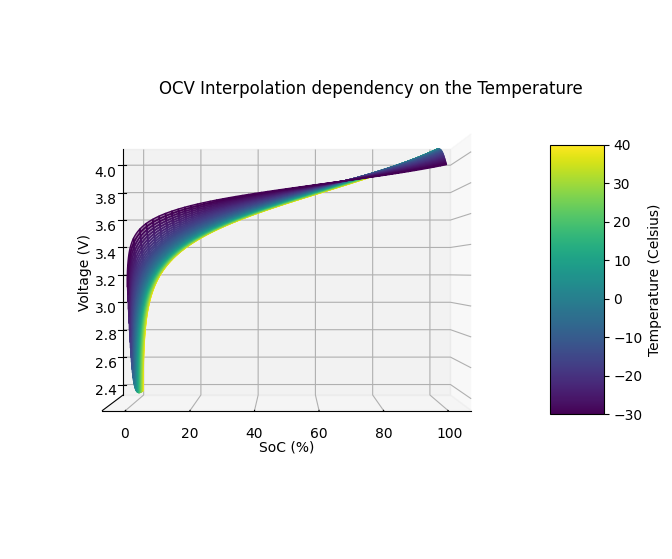

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable

# Parameters
b = 1.6
#b = b_coef
c = 1 
#c = c_coef
d = 3.8
#d = d_coef
f = popt_a[0]
g = popt_a[1]
h = popt_a[2]
print(f,g,h)
# Create data
soc = np.linspace(0.001, .999, 1000) # SoC
T = np.linspace(-30, 40, 100) # Temperature
X, Y = np.meshgrid(soc, T)
Z = f/(1+np.exp(-g*Y/10+h)) * np.arctanh(b*X-c) + d

# Normalize Y values (temperature) for coloring
norm = plt.Normalize(Y.min(), Y.max())  # Normalize temperature range
colors = plt.cm.viridis(norm(Y))  # Apply 'viridis' colormap based on temperature


# Create 3D plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X*100, Y, Z, cmap='viridis', alpha=.5, facecolors=colors)

# Add colorbar
mappable = ScalarMappable(norm=norm, cmap='viridis')
mappable.set_array(Y)
cbar = plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=5, pad=.001)
cbar.set_label('Temperature (Celsius)')

# Labels and show
plt.title('OCV Interpolation dependency on the Temperature', y=.9, x=.67)
ax.view_init(elev=0, azim=-90)
ax.set_xlabel('SoC (%)')
ax.set_yticks([],[])
#ax.set_ylabel('Temperature (Celsius)')
ax.set_zlabel('Voltage (V)')
plt.savefig('Rep 7/ocv_extrapolation_dep_temp.png')
plt.show()


# Compare general model with actual data

0.40462029615554407 0.9699935514422887 -2.651971222330788


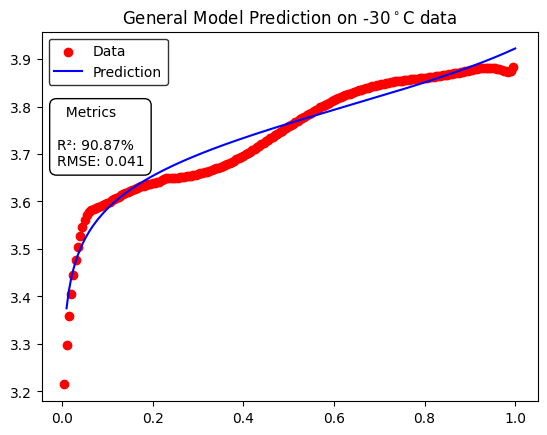

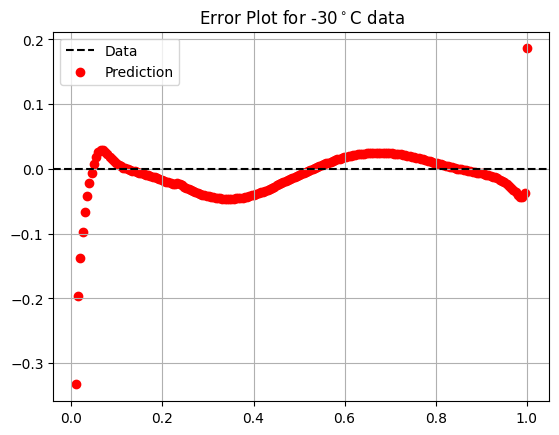

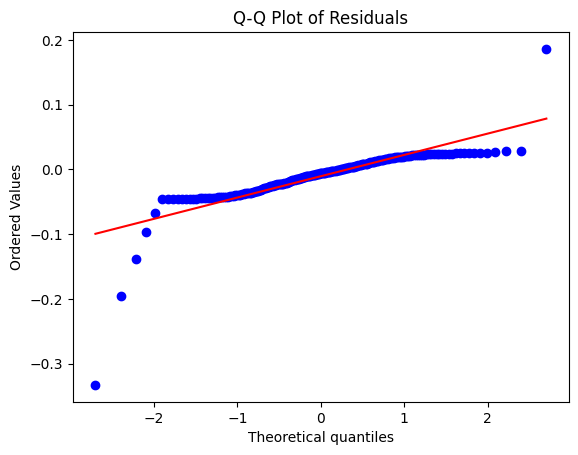

Durbin-Watson statistic: 0.23002010309587523
       lb_stat     lb_pvalue
10  278.159356  6.366295e-54
---------------------------------------------------




---------------------------------------------------


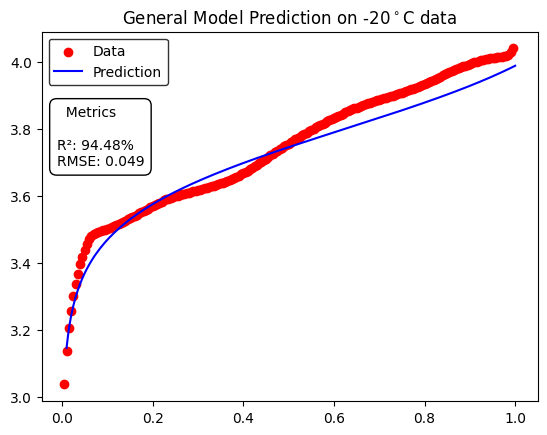

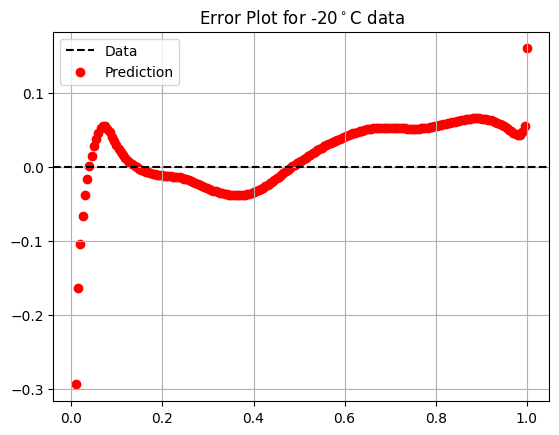

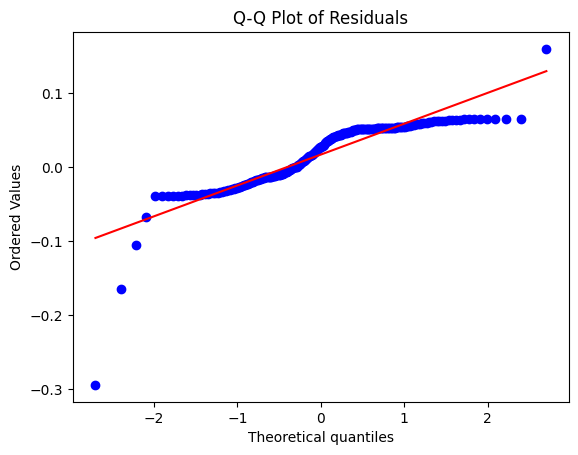

Durbin-Watson statistic: 0.07451256796467197
       lb_stat      lb_pvalue
10  763.088011  1.770419e-157
---------------------------------------------------




---------------------------------------------------


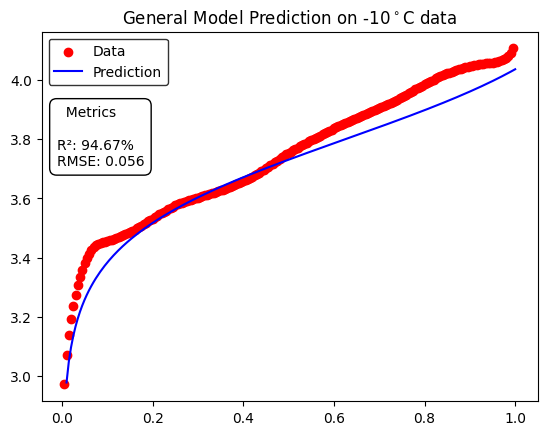

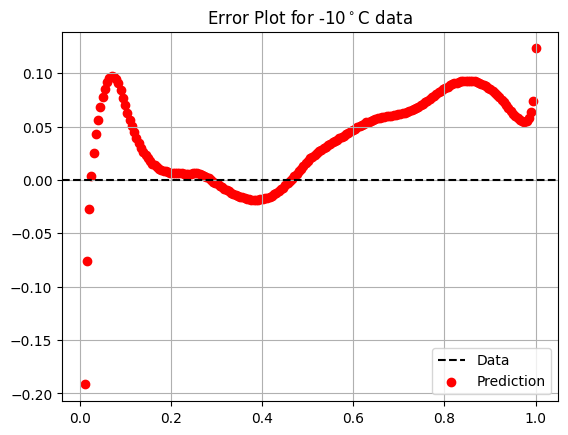

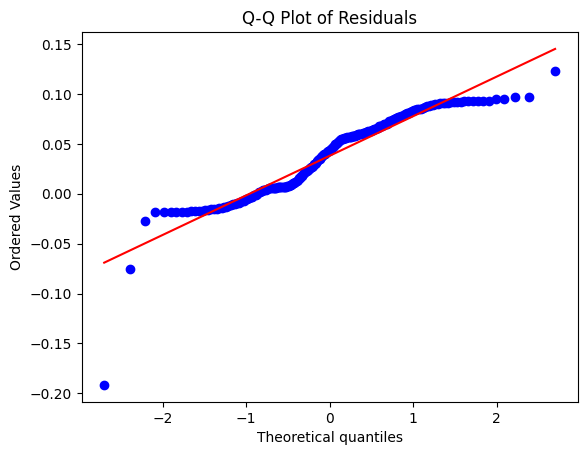

Durbin-Watson statistic: 0.03378282848710888
        lb_stat      lb_pvalue
10  1044.133103  5.799674e-218
---------------------------------------------------




---------------------------------------------------


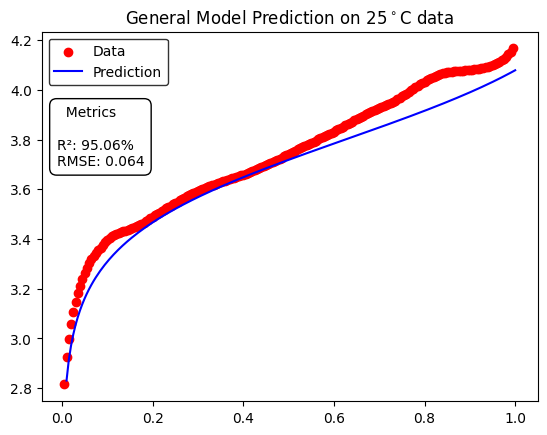

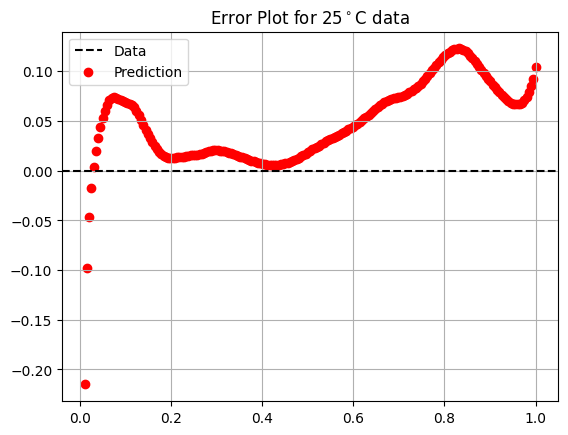

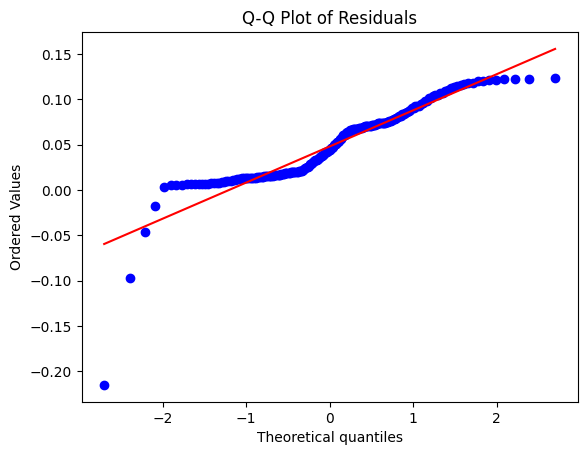

Durbin-Watson statistic: 0.02365826206160743
        lb_stat      lb_pvalue
10  1003.382734  3.493112e-209
---------------------------------------------------




---------------------------------------------------


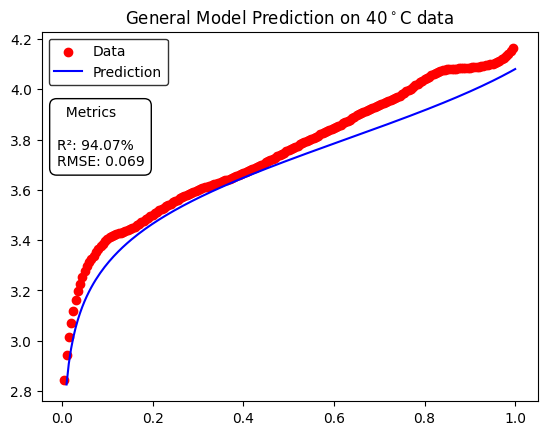

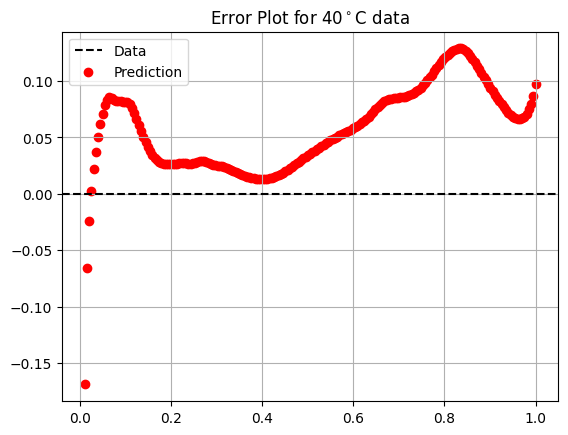

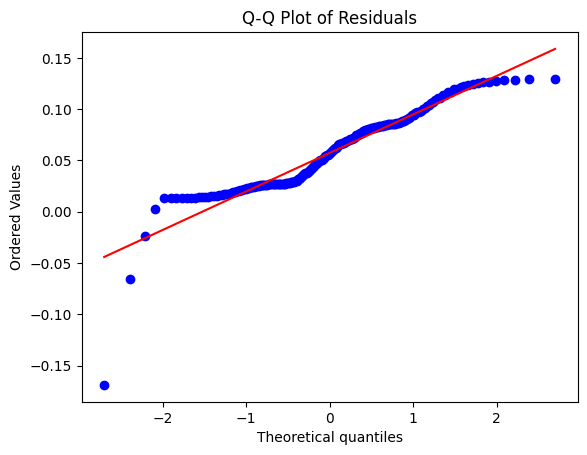

Durbin-Watson statistic: 0.015488416310540003
        lb_stat      lb_pvalue
10  1086.912961  3.495422e-227


In [18]:
from sklearn.metrics import r2_score, root_mean_squared_error
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
# Set default figure and axes facecolor to white
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# Set default text and axes color to black
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.titlecolor'] = 'black'

temps = [-30, -20, -10, 25, 40]
soc = np.linspace(0.01,1,201)
# Parameters
b = 1.6
#b = b_coef
c = 1 
#c = c_coef
d = 3.8
#d = d_coef
f = popt_a[0]
g = popt_a[1]
h = popt_a[2]
print(f,g,h)
for temp in temps:

    z = f/(1+np.exp(-g*temp/10+h)) * np.arctanh(b*soc-c) + d
    r2 = r2_score(sets[temp][volt_plot], z)
    rmse = root_mean_squared_error(sets[temp][volt_plot], z)
    
    error = sets[temp][volt_plot] - z
    
    
    plt.scatter(sets[temp][soc_plot][1:-1], sets[temp][volt_plot][1:-1], color='red', label='Data')
    plt.plot(soc, z, color='blue', label=f'Prediction')
    plt.title(f'General Model Prediction on {temp}$^\\circ$C data')
    plt.legend(edgecolor='black')
    metric_text = f'  Metrics  \n\nR²: {r2:.2%}\nRMSE: {rmse:.3f}'
    plt.text(0.03, 0.8, metric_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', 
                                                edgecolor='black', facecolor='white'))
    plt.savefig(f'Rep 7/{temp}_general_model_vs_data.png')
    plt.show()
    
    # create error plot
    plt.axhline(y=0, linestyle='--', color='black', label='Data')
    plt.scatter(soc, error, color='red', label='Prediction')
    plt.title(f'Error Plot for {temp}$^\\circ$C data')
    plt.legend()
    plt.grid()
    plt.savefig(f'Rep 7/{temp}_error_plot.png')
    plt.show()

    # Q - Q plot
    stats.probplot(error, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.show()
    
    # Statistics to say randomness of errors
    dw_statistic = durbin_watson(error)
    print(f'Durbin-Watson statistic: {dw_statistic}')
    lb_test = acorr_ljungbox(error, lags=[10], return_df=True)
    print(lb_test)
    
    
    if temp == temps[-1]:
        break
    print('---------------------------------------------------')
    print(end='\n\n\n\n')
    print('---------------------------------------------------')
    

In [19]:
# Parameters
b = 1.6
#b = b_coef
c = 1 
#c = c_coef
d = 3.8
#d = d_coef
f = popt_a[0]
g = popt_a[1]
h = popt_a[2]
# Create data
soc = np.linspace(0.01, 1, 100) # SoC
T = np.linspace(-30, 40, 71) # Temperature
Y, X = np.meshgrid(T, soc)
Z = np.round(f/(1+np.exp(-g*Y/10+h)) * np.arctanh(b*X-c) + d,3)

df = pd.DataFrame(Z, columns=T)
df.insert(0, 'SoC % \\ Temperature', soc*100)
df.to_excel('Rep 7/OCV_all_temp_minus_30_to_40.xlsx', index=False)


df

,SoC % \ Temperature,-30.0,-29.0,-28.0,-27.0,-26.0,-25.0,-24.0,-23.0,-22.0,...,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0
0,1.0,3.375,3.352,3.328,3.304,3.281,3.257,3.234,3.211,3.189,...,2.828,2.828,2.828,2.827,2.827,2.827,2.827,2.827,2.826,2.826
1,2.0,3.437,3.417,3.397,3.376,3.356,3.336,3.316,3.297,3.278,...,2.970,2.969,2.969,2.969,2.969,2.968,2.968,2.968,2.968,2.968
2,3.0,3.473,3.455,3.437,3.419,3.401,3.383,3.365,3.347,3.330,...,3.053,3.053,3.053,3.052,3.052,3.052,3.052,3.052,3.052,3.051
3,4.0,3.499,3.483,3.466,3.449,3.433,3.416,3.400,3.384,3.368,...,3.113,3.112,3.112,3.112,3.112,3.112,3.112,3.111,3.111,3.111
4,5.0,3.520,3.504,3.489,3.473,3.458,3.442,3.427,3.412,3.397,...,3.159,3.159,3.159,3.159,3.159,3.158,3.158,3.158,3.158,3.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96.0,3.906,3.911,3.917,3.923,3.929,3.935,3.941,3.946,3.952,...,4.041,4.041,4.041,4.042,4.042,4.042,4.042,4.042,4.042,4.042
96,97.0,3.910,3.916,3.922,3.928,3.934,3.940,3.946,3.952,3.958,...,4.050,4.051,4.051,4.051,4.051,4.051,4.051,4.051,4.051,4.051
97,98.0,3.914,3.920,3.926,3.933,3.939,3.945,3.951,3.957,3.963,...,4.060,4.060,4.060,4.060,4.060,4.060,4.060,4.060,4.060,4.060
98,99.0,3.918,3.924,3.931,3.937,3.944,3.951,3.957,3.963,3.970,...,4.070,4.070,4.070,4.070,4.070,4.070,4.070,4.070,4.070,4.070


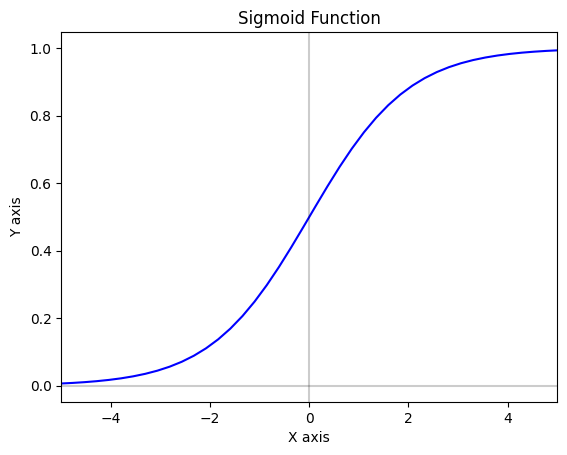

In [20]:
x = np.linspace(-6,6)
y = 1/(1+np.exp(-x))
plt.plot(x,y, color='blue')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.axvline(x=0, color ='black', alpha=0.2)
plt.axhline(y=0, color ='black', alpha=0.2)
plt.title('Sigmoid Function')
plt.xlim(-5,5)
plt.savefig('Rep 7/base_sigmoid_function.png')
plt.show()